In [ ]:
from act.cell_model import TargetCell, TrainCell
from act.simulator import Simulator
from act.act_types import SimulationParameters
# /Users/vladimiromelyusik/ACT/data/Burster/Izhikevich_p307_orig/template.hoc
# /Users/vladimiromelyusik/ACT/data/Burster/Izhikevich_p307_orig/modfiles
hoc_file = "/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/template.hoc"
mod_folder = "/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/modfiles"

### 1. Generate target data

In [ ]:
import numpy as np

num_samples = 10 # times 3 for each amp split

amps = []
for i in range(num_samples):
    amps.append(1)

for i in range(num_samples):
    amps.append(5)

for i in range(num_samples):
    amps.append(10)

print(len(amps))
# nap range: "high": 0.0006, "low": 0.0001
# kdr range: "high": 0.056, "low": 0.01
g_bars_nap = np.linspace(0.0001,0.0006,num_samples)
g_bars_kdr = np.linspace(0.01,0.056,num_samples)

gbars = []
for i in range(len(g_bars_kdr)):
    gbars.append([g_bars_nap[i],g_bars_kdr[i]])


gbars = gbars + gbars + gbars
print(len(gbars))

In [ ]:
# Init the cell
target_cell = TargetCell(
    hoc_file = hoc_file,
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "glbar_leak"]
)

In [ ]:
# Simulate a voltage trace
simulator = Simulator()
for i in range(len(gbars)):
    simulator.submit_job(
        target_cell,
        SimulationParameters(
            sim_name = "target1",
            h_v_init = -70, # (mV)
            h_tstop = 300,  # (ms)
            h_dt = 0.01, # (ms)
            h_celsius = 37, # (deg C)
            CI = {
                "type": "constant",
                "amp": amps[i],
                "dur": 290,
                "delay": 10
            }
        )
    )
# simulator.submit_job(...)
# simulator.submit_job(...)

In [ ]:
# Run
simulator.run(mod_folder)

### 2. Generate simulated data

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Total number of jobs: 1
Total number of proccessors: 192
Found 1 section(s) in this cell. Calculating the total surface area of the cell.


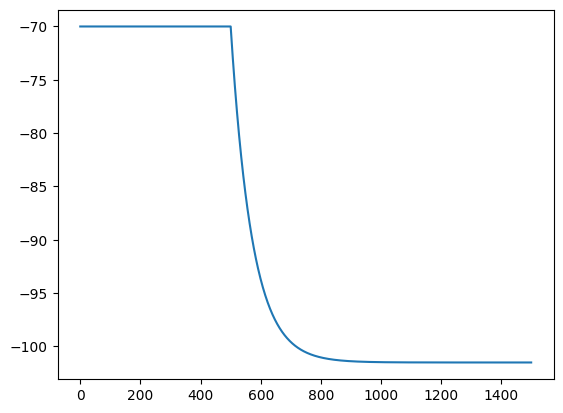

In [1]:
# Predict passive properties
from act.DataProcessor import DataProcessor
from act.cell_model import TrainCell
import matplotlib.pyplot as plt
import numpy as np

# Init the cell
train_cell = TrainCell(
    hoc_file = hoc_file,
    mod_folder= mod_folder,
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"]
)

# Simulate a negative current injection and get all of the data needed to calculate the passive properties.
# This is a stand in for data from a target cell.
dp = DataProcessor()
(
V,
dt, 
h_tstop, 
I_tstart, 
I_intensity,
cell_area
) = dp.simulate_negative_CI(train_cell, "glbar_leak")

plt.plot(V)

In [3]:
dp = DataProcessor()
props = dp.calculate_passive_properties(V, dt,h_tstop,I_tstart,I_intensity,cell_area,"glbar_leak")

print(props)

 v_rest: -70.0 v_final: -101.51961883559213
v_diff: 31.519618835592127 v_t_const: -89.92039910409423
index_v_tau: 72
{'leak_conductance_variable': 'glbar_leak', 'g_bar_leak': 3.500002954275104e-05, 'r_in': 315.19618835592127, 'tau': 72.0, 'v_rest': -70.0, 'Cm': 0.2284291582825145}


In [ ]:
from act.cell_model import TrainCell

# Init the cell
train_cell = TrainCell(
    hoc_file = hoc_file,
    mod_folder= mod_folder,
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"]
)


In [ ]:
# Simulate voltage traces
simulator = Simulator()

for i in range(len(gbars)):
    # Set parameters from the grid
    train_cell.set_g(["gbar_nap", "gkdrbar_kdr"], gbars[i])
    simulator.submit_job(
        train_cell, 
        SimulationParameters(
            sim_name = "train1",
            h_v_init = -70, # (mV)
            h_tstop = 300,  # (ms)
            h_dt = 0.01, # (ms)
            h_celsius = 37, # (deg C)
            CI = {
                "type": "constant",
                "amp": amps[i],
                "dur": 290,
                "delay": 10
            }
        )
    )
# simulator.submit_job(...)
# simulator.submit_job(...)

In [ ]:
# Run
simulator.run(mod_folder)

In [ ]:
# MatchFilter will go over saved data and create a dataset of the traces that match,
# deleting others

## 3. Train the model

In [ ]:
import numpy as np
from act.DataProcessor import DataProcessor
import matplotlib.pyplot as plt
import torch

# /home/mwsrgf/proj/ACT/model/train1/out.npy
data = np.load("/home/mwsrgf/proj/ACT/model/train1/out.npy")

# placeholder to show multiple runs
dataset =np.array([data,data,data,data,data])

def get_g(sample):
    conductances = sample[:, :, 2]
    trimmed_g = []
    for g in conductances:
        trimmed_g.append(np.nonzero(g))
    return torch.Tensor(trimmed_g)

print(dataset.shape)
#print(dataset)
#plt.plot(dataset[:,0])


V = dataset[:,:,0]
I = dataset[:,:,1]
g = get_g(dataset)
#print(dataset[:,:,2])
#print(V)
print(V.shape)
print(I.shape)

print(g)

dataprocessor = DataProcessor()
#summary_features, column_names = dataprocessor.extract_features(V, I, inj_dur=290, inj_start=10, fs=10)

#print(column_names)
#print(summary_features)


In [ ]:
import torch
def extract_spike_features(V: torch.Tensor, spike_threshold=0, n_spikes=20):
    # Get the number of threshold crossings
    threshold_crossings = torch.diff(V > spike_threshold, dim=1)

    # Get the number of spikes
    num_spikes = torch.round(torch.sum(threshold_crossings, dim=1) * 0.5)

    # Get the interspike times
    interspike_times = torch.zeros((V.shape[0], 1))
    for i in range(threshold_crossings.shape[0]):
        interspike_times[i, :] = torch.mean(
            torch.diff(
                torch.arange(threshold_crossings.shape[1])[threshold_crossings[i, :]]
            ).float()
        )
    interspike_times[torch.isnan(interspike_times)] = 0

    
    first_n_spikes = torch.zeros((V.shape[0], n_spikes)) * V.shape[1]
    avg_spike_min = torch.zeros((V.shape[0], 1))
    avg_spike_max = torch.zeros((V.shape[0], 1))
    for i in range(threshold_crossings.shape[0]):
        threshold_crossing_times = torch.arange(threshold_crossings.shape[1])[
            threshold_crossings[i, :]
        ]
        spike_times = []
        spike_mins = []
        spike_maxes = []
        for j in range(0, threshold_crossing_times.shape[0], 2):
            spike_times.append(threshold_crossing_times[j])
            ind = threshold_crossing_times[j : j + 2].cpu().tolist()
            end_ind = ind[1] if len(ind) == 2 else V.shape[1]
            spike_maxes.append(
                V[i][max(0, ind[0] - 1) : min(end_ind + 5, V.shape[1])].max()
            )
            spike_mins.append(
                V[i][max(0, ind[0] - 1) : min(end_ind + 5, V.shape[1])].min()
            )
        first_n_spikes[i][: min(n_spikes, len(spike_times))] = torch.tensor(
            spike_times
        ).flatten()[: min(n_spikes, len(spike_times))]
        avg_spike_max[i] = torch.mean(torch.tensor(spike_maxes).flatten())
        avg_spike_min[i] = torch.mean(torch.tensor(spike_mins).flatten())
        first_n_spikes_scaled = (
            first_n_spikes / V.shape[1]
        )  # may be good to return this
    return num_spikes, interspike_times, first_n_spikes_scaled, avg_spike_min, avg_spike_max

    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
test_trace = np.load("test_trace.npy")
trace = []
for i in test_trace:
    i = i/1000
    trace.append(i)


trace = torch.tensor(trace).unsqueeze(0)


print(trace)

# Print the shape to confirm it's now a 2D tensor
#print(trace_2d.shape)

plt.plot(trace[0].cpu().numpy())


(   num_spikes_simulated,
    simulated_interspike_times,
    first_n_spikes, 
    avg_spike_min,
    avg_spike_max
) = extract_spike_features(trace)

print(num_spikes_simulated)
print(simulated_interspike_times)
print(first_n_spikes)
print(avg_spike_max)
print(avg_spike_min)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time parameters
total_time = 1.0  # total time in seconds
step_start_time = 0.1  # step start time in seconds
step_end_time = 0.75  # step end time in seconds
step_value = 500  # step value in pA

# Define the sampling rate and create a time array
sampling_rate = 10000  # samples per second
time_array = np.linspace(0, total_time, int(total_time * sampling_rate))

# Generate the step input signal
step_input = np.zeros_like(time_array)
step_input[(time_array >= step_start_time) & (time_array <= step_end_time)] = step_value

# Plot the step input signal
plt.plot(time_array, step_input)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (pA)')
plt.title('Step Input Signal')
plt.grid(True)
plt.show()

In [ ]:
from act.DataProcessor import DataProcessor as dp
import matplotlib.pyplot as plt
import numpy as np
import torch
test_trace = np.load("test_trace.npy")
trace = []
for i in test_trace:
    i = i/1000
    trace.append(i)


trace = torch.tensor(trace).unsqueeze(0)

print(trace)



features, columns = dp.get_spike_stats(dp, trace)

print(columns)
print(features)

In [ ]:
from act.DataProcessor import DataProcessor
import matplotlib.pyplot as plt
import numpy as np
import torch

# Voltage Trace
test_trace = np.load("test_trace.npy")
trace = []
for i in test_trace:
    i = i/1000
    trace.append(i)


trace = torch.tensor(trace).unsqueeze(0)

#print(trace)

# Current Input
total_time = 1.0 
step_start_time = 0.1  
step_end_time = 0.75  
step_value = 500  

sampling_rate = 10000  
time_array = np.linspace(0, total_time, int(total_time * sampling_rate))


step_input = np.zeros_like(time_array)
step_input[(time_array >= step_start_time) & (time_array <= step_end_time)] = step_value

step_input = torch.Tensor(step_input)
# Test Dataprocessor
dp = DataProcessor()
features_to_extract = ["spikes","current"]
features, columns = dp.extract_features(features_to_extract, V=trace, I=step_input)

print(columns)
print(features)